In [1]:
## import
import torch,torchvision
from torch import nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F

In [3]:
img_size=32
channels=1
batch_size=32

In [4]:
## 数据准备
dataset=torchvision.datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(img_size),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]
    
    ) 
)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)
inputs,labels=next(iter(dataloader))
inputs.shape,labels.shape

100%|██████████| 9912422/9912422 [00:00<00:00, 333582419.28it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48146142.22it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 133195142.74it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6557841.23it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(torch.Size([32, 1, 32, 32]), torch.Size([32]))

In [5]:
## encoder
class Encoder(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        input_size=channels*img_size*img_size
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,self.z_dim)
        )
    def forward(self,x):
        return self.layers(x)
    
encoder=Encoder(100)
code=encoder(inputs)
code.shape

torch.Size([32, 100])

In [6]:
## decoder
class Decoder(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        output_size=channels*img_size*img_size
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            nn.Linear(self.z_dim,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,output_size),
            
        )
    def forward(self,x):
        return self.layers(x).view(-1,channels,img_size,img_size)
decoder=Decoder(100)
img=decoder(code)
img.shape

torch.Size([32, 1, 32, 32])

In [7]:
class Discriminator(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        input_size=channels*img_size*img_size+z_dim
        self.layers=nn.Sequential(
            nn.Linear(input_size,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1)
        )
        
    def forward(self,imgs,code):
        imgs=torch.flatten(imgs,1)
        inputs=torch.cat([imgs,code],dim=-1)
        #print(inputs.shape)
        return self.layers(inputs)
d=Discriminator(100)
d(inputs,code).shape
        
    

torch.Size([32, 1])

In [18]:
class BiGAN():
    def __init__(self,z_dim,device):
        self.z_dim=z_dim
        self.encoder=Encoder(self.z_dim).to(device)
        self.decoder=Decoder(self.z_dim).to(device)
        self.discriminator=Discriminator(self.z_dim).to(device)
    def Encoder(self,x):
        return self.encoder(x)
    def Decoder(self,x):
        return self.decoder(x)
    
    def Dis(self,x,z):
        return self.discriminator(x,z)

In [9]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
z_dim=100
lr=0.0002
b1=0.5
b2=0.999
epochs=50

In [19]:
import itertools
dis_loss = torch.nn.BCEWithLogitsLoss()
bi_gan=BiGAN(100,device)
optimizer_encoder_decoder = torch.optim.Adam(itertools.chain(bi_gan.encoder.parameters(),bi_gan.decoder.parameters()), lr=lr, betas=(b1, b2))
optimizer_dis = torch.optim.Adam(bi_gan.discriminator.parameters(), lr=lr, betas=(b1, b2))



In [17]:
cuda=1 if torch.cuda.is_available() else 0
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()


In [30]:
g_loss_list=[]
d_loss_list=[]
for epoch in range(epochs):
    for i,(imgs,labels) in enumerate(dataloader):
        batch_size=imgs.shape[0]
        
        valid=FloatTensor(np.ones((batch_size,1)))
        fake=FloatTensor(np.zeros((batch_size,1)))
        
        optimizer_encoder_decoder.zero_grad()
        
        x=imgs.to(device)
        z_=bi_gan.Encoder(x)
        
        z=FloatTensor(np.random.normal(size=(batch_size,bi_gan.z_dim)))
        x_=bi_gan.Decoder(z)
        
        dis_true=bi_gan.Dis(x,z_)
        dis_fake=bi_gan.Dis(x_,z)
        
        g_loss=(dis_loss(dis_true,fake)+dis_loss(dis_fake,valid))/2
        g_loss.backward()
        optimizer_encoder_decoder.step()
        
        optimizer_dis.zero_grad()
        dis_true=bi_gan.Dis(x,z_.detach())
        dis_fake=bi_gan.Dis(x_.detach(),z)
        
        d_loss=(dis_loss(dis_true,valid)+dis_loss(dis_fake,fake))/2
        d_loss.backward()
        optimizer_dis.step()
        
        g_loss_list.append(g_loss.item())
        d_loss_list.append(d_loss.item())
        
        batch_done=epoch*len(dataloader)+i
        if(batch_done%100==0):
            clear_output()
            print('[Epoch %d/%d]:'%(epoch,epochs))
            show(x_)
            plt.plot(range(batch_done+1),g_loss_list)
            plt.plot(range(batch_done+1),d_loss_list)
            plt.show()
        
        

[Epoch 10/50]:


KeyboardInterrupt: 

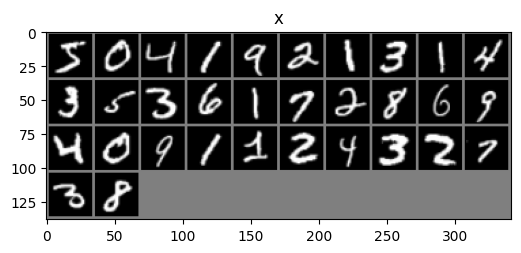

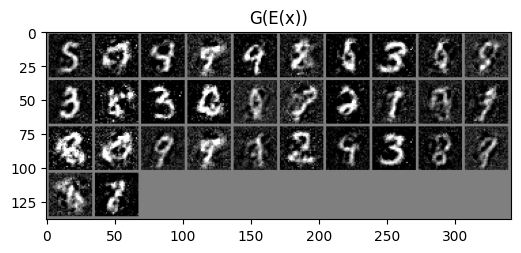

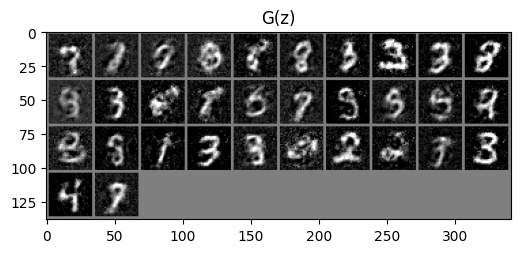

In [32]:
def show(imgs,title='G(z)',figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.title(title)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
z=FloatTensor(np.random.normal(size=(batch_size,bi_gan.z_dim)))
rec_imgs=bi_gan.Decoder(bi_gan.Encoder(inputs.cuda()))
gen_imgs=bi_gan.Decoder(z)
show(inputs,'x')
show(rec_imgs,'G(E(x))')
show(gen_imgs,'G(z)')